In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import re
from glob import glob

# Pipeline:

- prepare sample table
- run trimming to remove adapters and primers
- run dada2 to generate ASVs, remove chimeras, and abundance table
- run nextclade to call SNVs and indels


TO-DO:

Turn pipeline into an executable that takes sample table as input

# Set up sample directory
1. download reads into data/raw
2. make read_list.txt (ls \*R1\*.fastq.gz > reads_list.txt)
3. make subdirectories within data/raw for each amplicon
4. make trimmed_reads directories for each amplicon (e.g. data/raw/ntd/trimmed_reads)

# Make sample table (can do this in a spreadsheet or here)

**sample table must have columns:**

- read1 # basename of read file 1 (e.g. "NTD_I_I_INF_101321_1_S58_L001_R2_001.fastq.gz")
- read2 # created off of read1
- amplicon # extracted from read1 (e.g. "NTD")
- sample_id # extracted from read1, following lab convention (e.g. "I_I_INF_101321_1")
- merge_id # same as sample_id, or a replicate sample with a Cq value in qPCR table (if the sample sent for sequencing was not analyzed via qPCR)
- treatment # any upstream non-standard treatment performed on the sample or RNA (e.g. "rRd" for RNA depletion)
- datadir # location of read1 and read2 files

In [2]:
# 10/4/21
# # samples given to Justin were run with RBD primers only and were processed with rRNA depletion ('rRd') or without ('STD')
# # samples run in-house were labeled "RBD"

datadir = '/Users/rosekantor/data/wbe_scv/qb3_sgene_100421'
reads_df = pd.read_csv(f'{datadir}/raw/reads_list.txt', names=['read1'])

reads_df = reads_df[~reads_df.read1.str.contains('Undetermined')]
reads_df['read2'] = reads_df.read1.str.replace(r'_R1_', '_R2_')
reads_df[['amplicon','sample_id']] = reads_df.read1.str.extract(r'(\w+)_(.+_.+_.+_\d+_\d+)_S\d+_L001_R._001\.fastq\.gz')
reads_df['merge_id'] = reads_df['sample_id'].copy()
reads_df['treatment'] = 'inhouse'
reads_df.loc[reads_df.amplicon == 'rRd', 'treatment'] = 'rRd'
reads_df.loc[reads_df.treatment == 'rRd', 'amplicon'] = 'RBD' # rename amplicon, all ribodepleted samples were RBD this round
reads_df.loc[reads_df.amplicon == 'STD', 'treatment'] = 'std'
reads_df.loc[reads_df.amplicon == 'STD', 'amplicon'] = 'RBD' # the non-ribodepleted amplicons from FGL were RBD but got named "STD" for standard treatment
reads_df['datadir'] = datadir

# In this run, the same samples were run with and without ribodepletion. Give these unique names:
reads_df.loc[reads_df.treatment.isin(['std', 'rRd']), 'sample_id'] = reads_df.treatment + "_" + reads_df.sample_id

reads_df.to_csv(f'{datadir}/sample_table.csv', index=False)

In [3]:
# 11/5/21
# samples all processed with rRNA depletion at FGL/GSL

datadir = '/Users/rosekantor/data/wbe_scv/qb3_sgene_110521'
reads_df = pd.read_csv(f'{datadir}/raw/reads_list.txt', names=['read1'])

reads_df = reads_df[~reads_df.read1.str.contains('Undetermined')]
reads_df['read2'] = reads_df.read1.str.replace(r'_R1_', '_R2_')
reads_df['read_name'] = reads_df.read1.str.replace('Twist_2_23', 'control_Twist_2_23_101521') # to match pattern
reads_df['read_name'] = reads_df.read_name.str.replace('control_PBS', 'control_control_PBS') # to match pattern
reads_df[['amplicon','sample_id']] = reads_df.read_name.str.extract(r'(\w+)_(.+_.+_.+_\d+_\d+)_S\d+_L001_R._001\.fastq\.gz')
reads_df['merge_id'] = reads_df['sample_id'].copy()
reads_df['treatment'] = 'rRd' # all were ribodepleted
reads_df['datadir'] = datadir

reads_df.to_csv(f'{datadir}/sample_table.csv', index=False)

In [4]:
# 11/19/21

# samples all processed with rRNA depletion at FGL/GSL

datadir = '/Users/rosekantor/data/wbe_scv/qb3_sgene_111921'
reads_df = pd.read_csv(f'{datadir}/raw/reads_list.txt', names=['read1'])

reads_df = reads_df[~reads_df.read1.str.contains('Undetermined')]
reads_df['read2'] = reads_df.read1.str.replace(r'_R1_', '_R2_')
reads_df['read_name'] = reads_df.read1.str.replace('Twistcontrol', 'control_Twist_2_23_110121') # to match pattern
reads_df[['amplicon','sample_id']] = reads_df.read_name.str.extract(r'(\w+)_(.+_.+_.+_\d+_\d+)_S\d+_L001_R._001\.fastq\.gz')
reads_df['merge_id'] = reads_df['sample_id'].copy()
reads_df['treatment'] = 'rRd' # all were ribodepleted
reads_df['datadir'] = datadir

reads_df.to_csv(f'{datadir}/sample_table.csv', index=False)

In [5]:
# 12/7/21

# samples all processed with rRNA depletion at FGL/GSL

datadir = '/Users/rosekantor/data/wbe_scv/qb3_sgene_120721'
reads_df = pd.read_csv(f'{datadir}/raw/reads_list.txt', names=['read1'])

reads_df = reads_df[~reads_df.read1.str.contains('Undetermined')]
reads_df['read2'] = reads_df.read1.str.replace(r'_R1_', '_R2_')
reads_df['read_name'] = reads_df.read1.str.replace('Twist_control', 'control_Twist_2_23_111521') # to match pattern
reads_df['read_name'] = reads_df.read_name.str.replace('control_PBS', 'control_control_PBS') # to match pattern
reads_df[['amplicon','sample_id']] = reads_df.read_name.str.extract(r'(\w+)_(.+_.+_.+_\d+_\d+)_S\d+_L001_R._001\.fastq\.gz')
reads_df['merge_id'] = reads_df['sample_id'].copy()
reads_df['treatment'] = 'rRd' # all were ribodepleted
reads_df['datadir'] = datadir

# RBD got named RDB in the reads names
reads_df.loc[reads_df.amplicon == 'RDB', 'amplicon'] = 'RBD'

reads_df.to_csv(f'{datadir}/sample_table.csv', index=False)

In [6]:
# 12/13/21 (samples submitted 11/29/21)

# samples all processed with rRNA depletion at FGL/GSL

datadir = '/Users/rosekantor/data/wbe_scv/qb3_sgene_121321'
reads_df = pd.read_csv(f'{datadir}/raw/reads_list.txt', names=['read1'])

reads_df = reads_df[~reads_df.read1.str.contains('Undetermined')]
reads_df['read2'] = reads_df.read1.str.replace(r'_R1_', '_R2_')
reads_df['read_name'] = reads_df.read1.str.replace('Twist_control', 'control_Twist_2_23_112921') # to match pattern
reads_df['read_name'] = reads_df.read_name.str.replace('control_PBS', 'control_control_PBS') # to match pattern
reads_df[['amplicon','sample_id']] = reads_df.read_name.str.extract(r'(\w+)_(.+_.+_.+_\d+_\d+)_S\d+_L001_R._001\.fastq\.gz')
reads_df['merge_id'] = reads_df['sample_id'].copy()
reads_df['treatment'] = 'rRd' # all were ribodepleted
reads_df['datadir'] = datadir

# RBD got named RDB in the reads names
reads_df.loc[reads_df.amplicon == 'RDB', 'amplicon'] = 'RBD'

reads_df.to_csv(f'{datadir}/sample_table.csv', index=False)

In [32]:
# # 12/23/21 (samples submitted 12/13/21)
# # no rRNA depletion was performed (out of RiboCop)
# # all samples processed at FGL/GSL

# # NOTE: this run was very poor quality
# datadir = '/Users/rosekantor/data/wbe_scv/qb3_sgene_122321'
# reads_df = pd.read_csv(f'{datadir}/raw/reads_list.txt', names=['read1'])

# reads_df = reads_df[~reads_df.read1.str.contains('Undetermined')]
# reads_df['read2'] = reads_df.read1.str.replace(r'_R1_', '_R2_')
# reads_df['read_name'] = reads_df.read1.str.replace('Twist_control', 'control_Twist_2_23_122321') # to match pattern
# reads_df['read_name'] = reads_df.read_name.str.replace('control_PBS', 'control_control_PBS') # to match pattern
# reads_df[['amplicon','sample_id']] = reads_df.read_name.str.extract(r'(\w{3,4})_(.+)_S\d+_L001_R._001\.fastq\.gz')

# # these samples got misnamed with the shorthand name
# reads_df.sample_id = reads_df.sample_id.str.replace(r'C_INF', 'C_C_INF')
# reads_df.sample_id = reads_df.sample_id.str.replace(r'K_INF', 'K_K_INF')
# reads_df.sample_id = reads_df.sample_id.str.replace(r'U_INF', 'U_U_INF')
# reads_df.sample_id = reads_df.sample_id.str.replace(r'V_INF', 'V_V_INF')
# reads_df.sample_id = reads_df.sample_id.str.replace(r'W_INF', 'W_W_INF')
# reads_df.sample_id = reads_df.sample_id.str.replace(r'Y_INF', 'Y_Y_INF')

# reads_df['merge_id'] = reads_df['sample_id'].copy()
# reads_df['treatment'] = 'std' # no ribodepletion
# reads_df['datadir'] = datadir

# reads_df.to_csv(f'{datadir}/sample_table.csv', index=False)

In [ ]:
# samples submitted 12/13/21 to U Missouri
# no rRNA depletion was performed

# NOTE: the RBD and NTD amplicons were pooled for each sample before sequencing
# will process each pool twice- once with trimming parameters set for each amplicon
# this should pull them apart based on which primers are present in the reads
datadir = '/Users/rosekantor/data/wbe_scv/umissouri_sgene_122321'
reads_df = pd.read_csv(f'{datadir}/raw/reads_list.txt', names=['read1'])
reads_df['read2'] = reads_df.read1.str.replace(r'_R1_', '_R2_')

# full sample IDs are not given in the reads, but they should be identical to the ones we submitted to QB3 in the first batch that failed 
# (it is being redone at QB3 with other extraction replicates)
sample_id = ['D_OSP_INF_120821_1',
 'D_OSP_INF_120121_1',
 'D_SEP_INF_120821_1',
 'K_K_INF_120121_1',
 'K_K_INF_120821_1',
 'U_U_INF_120821_2',
 'V_V_INF_120821_1',
 'X_2_INF_120221_1',
 'X_2_INF_120921_2',
 'Y_Y_INF_113021_3' 
]

reads_df['sample_id'] = sample_id
reads_df['merge_id'] = sample_id
reads_df['read_name'] = reads_df.read1.copy()
reads_df['treatment'] = 'umissouri' # no ribodepletion
reads_df['datadir'] = datadir

rbd = reads_df[reads_df.read1.str.contains('RBD')].copy()
rbd['amplicon'] = 'RBD'
ntd = reads_df[reads_df.read1.str.contains('NTD')].copy()
ntd['amplicon'] = 'NTD'

reads_df = pd.concat([rbd, ntd])

reads_df.to_csv(f'{datadir}/sample_table.csv', index=False)

In [ ]:
# 01/24/22 (samples submitted from multiple batches)
# all samples processed at FGL/GSL with RiboCop

# excellent quality (lots of COVID cases)

datadir = '/Users/rosekantor/data/wbe_scv/qb3_sgene_012422'
reads_df = pd.read_csv(f'{datadir}/raw/reads_list.txt', names=['read1'])

reads_df = reads_df[~reads_df.read1.str.contains('Undetermined')]
reads_df['read2'] = reads_df.read1.str.replace(r'_R1_', '_R2_')
reads_df['read_name'] = reads_df.read1.str.replace('twist_control', 'control_Twist_2_23_012422') # to match pattern
reads_df['read_name'] = reads_df.read_name.str.replace('control_PBS', 'control_control_PBS') # to match pattern
reads_df[['amplicon','sample_id']] = reads_df.read_name.str.extract(r'(\w{3,4})_(.+)_S\d+_L001_R._001\.fastq\.gz')
reads_df['merge_id'] = reads_df['sample_id'].copy()
reads_df['treatment'] = 'rRd' # ribodepletion
reads_df['datadir'] = datadir

reads_df.to_csv(f'{datadir}/sample_table.csv', index=False)

In [ ]:
# 02/04/22 (samples submitted from multiple batches) - 
# some are reruns of the 12/13/21 batch, reprocessed with RiboCop + PCR performed at FGL
# some are from ultrafiltration and QIAamp viral RNA mini extractions + PCR performed in-house
# all samples sequenced at FGL/GSL

datadir = '/Users/rosekantor/data/wbe_scv/qb3_sgene_020422'
reads_df = pd.read_csv(f'{datadir}/raw/reads_list.txt', names=['read1'])

reads_df = reads_df[~reads_df.read1.str.contains('Undetermined')]
reads_df['read2'] = reads_df.read1.str.replace(r'_R1_', '_R2_')
reads_df['read_name'] = reads_df.read1.str.replace(r'[tT]wist_control', 'control_Twist_2_23_020422', regex=True) # to match pattern
reads_df['read_name'] = reads_df.read_name.str.replace('control_PBS', 'control_control_PBS') # to match pattern
reads_df[['amplicon','sample_id']] = reads_df.read_name.str.extract(r'(\w{3,4})_(.+)_S\d+_L001_R._001\.fastq\.gz')
reads_df['merge_id'] = reads_df['sample_id'].copy()

reads_df['datadir'] = datadir

# these samples got misnamed with the shorthand name
reads_df.sample_id = reads_df.sample_id.str.replace(r'^C_INF', 'C_C_INF', regex=True)
reads_df.sample_id = reads_df.sample_id.str.replace(r'^K_INF', 'K_K_INF', regex=True)
reads_df.sample_id = reads_df.sample_id.str.replace(r'^U_INF', 'U_U_INF', regex=True)
reads_df.sample_id = reads_df.sample_id.str.replace(r'^V_INF', 'V_V_INF', regex=True)
reads_df.sample_id = reads_df.sample_id.str.replace(r'^W_INF', 'W_W_INF', regex=True)
reads_df.sample_id = reads_df.sample_id.str.replace(r'^Y_INF', 'Y_Y_INF', regex=True)

reads_df['treatment'] = 'std' # after 1/2022, no ribodepletion
reads_df.loc[reads_df.sample_id.str.contains('21_'), 'treatment'] = 'rRd' # from Dec 2021, this is the redo with rRd (previous run as std failed)
reads_df.loc[reads_df.sample_id.str.endswith('_4'), 'treatment'] = 'amicon'


reads_df.to_csv(f'{datadir}/sample_table.csv', index=False)

In [ ]:
# 02/15/22 (samples submitted from multiple batches) - 
# some are from the 12/20 batch
# some are from ultrafiltration and QIAamp viral RNA mini extractions + PCR performed in-house
# some are from CDPH lab
# all samples sequenced at FGL/GSL

datadir = '/Users/rosekantor/data/wbe_scv/qb3_sgene_021522'
reads_df = pd.read_csv(f'{datadir}/raw/reads_list.txt', names=['read1'])

reads_df = reads_df[~reads_df.read1.str.contains('Undetermined')]
reads_df['read2'] = reads_df.read1.str.replace(r'_R1_', '_R2_')
reads_df['read_name'] = reads_df.read1.str.replace(r'[tT]wist_control', 'control_Twist_2_23_020422', regex=True) # to match pattern
reads_df[['amplicon','sample_id']] = reads_df.read_name.str.extract(r'(\w{3,4})_(.+)_S\d+_L001_R._001\.fastq\.gz')
reads_df['merge_id'] = reads_df['sample_id'].copy()

reads_df['datadir'] = datadir


reads_df['treatment'] = 'std' # after 1/2022, no ribodepletion
reads_df.loc[reads_df.sample_id.str.contains('21_'), 'treatment'] = 'rRd' # from Dec 2021, this is the redo with rRd (previous run as std failed)
reads_df.loc[reads_df.sample_id.str.endswith('_4'), 'treatment'] = 'amicon' # from Dec 2021, this is the redo with rRd (previous run as std failed)

reads_df.to_csv(f'{datadir}/sample_table.csv', index=False)
reads_df

In [41]:
# 03/08/22 (samples submitted from multiple batches) - 
# some are from rRNA depletion of 4S samples
# some are from CDPH lab
# all samples sequenced at FGL/GSL

datadir = '/Users/rosekantor/data/wbe_scv/qb3_sgene_030822'
reads_df = pd.read_csv(f'{datadir}/raw/reads_list.txt', names=['read1'])

reads_df = reads_df[~reads_df.read1.str.contains('Undetermined')]
reads_df['read2'] = reads_df.read1.str.replace(r'_R1_', '_R2_')
reads_df['read_name'] = reads_df.read1.str.replace(r'control_control_bCoV_020522_H31', 'control_control_bCoV_020522_1', regex=True) # to match pattern
reads_df[['amplicon','sample_id']] = reads_df.read_name.str.extract(r'(\w{3,4})_(.+)_S\d+_L001_R._001\.fastq\.gz')
reads_df['merge_id'] = reads_df['sample_id'].copy()

reads_df['datadir'] = datadir

reads_df.loc[reads_df.amplicon == 'ntd', 'amplicon'] = 'NTD'
reads_df.loc[reads_df.amplicon == 'rbd', 'amplicon'] = 'RBD'

reads_df['treatment'] = 'std'
reads_df.loc[reads_df.sample_id.str.endswith('_1'), 'treatment'] = 'rRd'
reads_df.loc[reads_df.sample_id.str.endswith('_4'), 'treatment'] = 'amicon'
reads_df.loc[reads_df.sample_id.str.contains('LACSD_Jnt_INF'), 'treatment'] = 'cdph'
reads_df.loc[reads_df.sample_id.str.contains('OCSD_P1_INF'), 'treatment'] = 'cdph'
reads_df.loc[reads_df.sample_id.str.contains('SDPU_PtLom_INF'), 'treatment'] = 'cdph'

# NOTE: LACSD_Jnt_INF_012322_1 is a rerun of a failed sample; had to change to "LACSD_Jnt_INF_012322_2" after the fact so that tables could be merged by dada2


reads_df.to_csv(f'{datadir}/sample_table.csv', index=False)

In [161]:
# 03/28/22 
# all samples are 4S ribodepleted
# all samples sequenced at FGL/GSL

datadir = '/Users/rosekantor/data/wbe_scv/qb3_sgene_032822'
reads_df = pd.read_csv(f'{datadir}/raw/reads_list.txt', names=['read1'])

reads_df['read2'] = reads_df.read1.str.replace(r'_R1_', '_R2_')
reads_df[['amplicon','sample_id']] = reads_df.read1.str.extract(r'(\w{3,4})_(.+)_S\d+_L001_R._001\.fastq\.gz')
reads_df['read_name'] = reads_df.read1
reads_df['merge_id'] = reads_df['sample_id'].copy()

reads_df['datadir'] = datadir

reads_df.loc[reads_df.amplicon == 'ntd', 'amplicon'] = 'NTD'
reads_df.loc[reads_df.amplicon == 'RDB', 'amplicon'] = 'RBD' # misnamed

reads_df['treatment'] = 'rRd'

reads_df.to_csv(f'{datadir}/sample_table.csv', index=False)

In [36]:
# 4/2/22 samples sent to U Missouri (3 were sequenced with normal primers, 7 were sequenced with non-omicron primers)


datadir = '/Users/rosekantor/data/wbe_scv/umissouri_sgene_040222'
reads_df = pd.read_csv(f'{datadir}/raw/reads_list.txt', names=['read1'])

reads_df['read2'] = reads_df.read1.str.replace(r'_R1_', '_R2_')
 #CA5-1_RBD_D09_S45_L001_R1_001.fastq.gz


reads_df['read_name'] = reads_df.read1.str.extract(r'(CA5-\d+)_.*')

reads2samples = pd.DataFrame.from_dict({'sample_id': ['C_C_INF_030922_3', 'V_V_INF_030922_3', 'W_W_INF_031022_3'],
                                        'read_name': ['CA5-1', 'CA5-3', 'CA5-5']})
reads_df = reads_df.merge(reads2samples)


reads_df['datadir'] = datadir

reads_df['amplicon'] = 'RBD'

reads_df['treatment'] = 'UM'

reads_df.to_csv(f'{datadir}/sample_table.csv', index=False)

In [45]:
# 4/8/22 samples sent to U Missouri (sequenced with normal primers, also sequenced with non-omicron primers, but not analyzing that data here)

datadir = '/Users/rosekantor/data/wbe_scv/umissouri_sgene_040822'
reads_df = pd.read_csv(f'{datadir}/raw/reads_list.txt', names=['read1'])
reads_df['read2'] = reads_df.read1.str.replace(r'_R1_', '_R2_')
reads_df['read_name'] = reads_df.read1.str.extract(r'(CA[56]-\d+)_.*')

reads2samples = pd.read_csv(f'{datadir}/sample_names.csv')
reads_df = reads_df.merge(reads2samples[['sample_id', 'umissouri code']], how='left', left_on='read_name', right_on='umissouri code')

reads_df['datadir'] = datadir
reads_df['amplicon'] = 'RBD'
reads_df['treatment'] = 'UM'

reads_df.to_csv(f'{datadir}/sample_table.csv', index=False)

In [158]:
# 4/25/22 samples sent to U Missouri (sequenced with normal primers, also sequenced with non-omicron primers, but not analyzing that data here)

datadir = '/Users/rosekantor/data/wbe_scv/umissouri_sgene_042522'
reads_df = pd.read_csv(f'{datadir}/raw/reads_list.txt', names=['read1'])
reads_df['read2'] = reads_df.read1.str.replace(r'_R1_', '_R2_')
reads_df['read_name'] = reads_df.read1.str.extract(r'(CA[7]-\d+)_.*')

reads2samples = pd.read_csv(f'{datadir}/sample_names.csv')
reads_df = reads_df.merge(reads2samples[['sample_id', 'umissouri code']], how='left', left_on='read_name', right_on='umissouri code')

reads_df['datadir'] = datadir
reads_df['amplicon'] = 'RBD'
reads_df['treatment'] = 'UM'

reads_df.to_csv(f'{datadir}/sample_table.csv', index=False)
reads_df

,read1,read2,read_name,sample_id,umissouri code,datadir,amplicon,treatment
0,CA7-1_RBD_F05_S65_L001_R1_001.fastq.gz,CA7-1_RBD_F05_S65_L001_R2_001.fastq.gz,CA7-1,B_B_INF_040522_4,CA7-1,/Users/rosekantor/data/wbe_scv/umissouri_sgene...,RBD,UM
1,CA7-2_RBD_F06_S66_L001_R1_001.fastq.gz,CA7-2_RBD_F06_S66_L001_R2_001.fastq.gz,CA7-2,L_L_INF_040422_4,CA7-2,/Users/rosekantor/data/wbe_scv/umissouri_sgene...,RBD,UM
2,CA7-3_RBD_F07_S67_L001_R1_001.fastq.gz,CA7-3_RBD_F07_S67_L001_R2_001.fastq.gz,CA7-3,B_B_SRWS_041022_4,CA7-3,/Users/rosekantor/data/wbe_scv/umissouri_sgene...,RBD,UM
3,CA7-5_RBD_F08_S68_L001_R1_001.fastq.gz,CA7-5_RBD_F08_S68_L001_R2_001.fastq.gz,CA7-5,K_K_INF_040722_4,CA7-5,/Users/rosekantor/data/wbe_scv/umissouri_sgene...,RBD,UM
4,CA7-6_RBD_F09_S69_L001_R1_001.fastq.gz,CA7-6_RBD_F09_S69_L001_R2_001.fastq.gz,CA7-6,F_F_INF_040622_4,CA7-6,/Users/rosekantor/data/wbe_scv/umissouri_sgene...,RBD,UM
5,CA7-7_RBD_F10_S70_L001_R1_001.fastq.gz,CA7-7_RBD_F10_S70_L001_R2_001.fastq.gz,CA7-7,M_M_INF_040522_4,CA7-7,/Users/rosekantor/data/wbe_scv/umissouri_sgene...,RBD,UM


In [164]:
# 4/25/22 samples sent to U Missouri (sequenced with normal primers, also sequenced with non-omicron primers, but not analyzing that data here)

datadir = '/Users/rosekantor/data/wbe_scv/umissouri_sgene_052222'
reads_df = pd.read_csv(f'{datadir}/raw/reads_list.txt', names=['read1'])
reads_df['read2'] = reads_df.read1.str.replace(r'_R1_', '_R2_')
reads_df['read_name'] = reads_df.read1.str.extract(r'(CA[8]-\d+)_.*')

reads2samples = pd.read_csv(f'{datadir}/sample_names.csv')
reads_df = reads_df.merge(reads2samples[['sample_id', 'umissouri code']], how='left', left_on='read_name', right_on='umissouri code')

reads_df['datadir'] = datadir
reads_df['amplicon'] = 'RBD'
reads_df['treatment'] = 'UM'

#reads_df.to_csv(f'{datadir}/sample_table.csv', index=False)
reads_df

,read1,read2,read_name,sample_id,umissouri code,datadir,amplicon,treatment
0,CA8-10_RBD_G02_S74_L001_R1_001.fastq.gz,CA8-10_RBD_G02_S74_L001_R2_001.fastq.gz,CA8-10,D_SEP_INF_042722_4,CA8-10,/Users/rosekantor/data/wbe_scv/umissouri_sgene...,RBD,UM
1,CA8-11_RBD_G03_S75_L001_R1_001.fastq.gz,CA8-11_RBD_G03_S75_L001_R2_001.fastq.gz,CA8-11,D_OSP_INF_042722_3,CA8-11,/Users/rosekantor/data/wbe_scv/umissouri_sgene...,RBD,UM
2,CA8-12_RBD_G04_S76_L001_R1_001.fastq.gz,CA8-12_RBD_G04_S76_L001_R2_001.fastq.gz,CA8-12,D_OSP_INF_042722_4,CA8-12,/Users/rosekantor/data/wbe_scv/umissouri_sgene...,RBD,UM
3,CA8-13_RBD_G05_S77_L001_R1_001.fastq.gz,CA8-13_RBD_G05_S77_L001_R2_001.fastq.gz,CA8-13,B_B_SRWS_050822_4,CA8-13,/Users/rosekantor/data/wbe_scv/umissouri_sgene...,RBD,UM
4,CA8-14_RBD_G06_S78_L001_R1_001.fastq.gz,CA8-14_RBD_G06_S78_L001_R2_001.fastq.gz,CA8-14,B_B_INF_050322_4,CA8-14,/Users/rosekantor/data/wbe_scv/umissouri_sgene...,RBD,UM
5,CA8-15_RBD_G07_S79_L001_R1_001.fastq.gz,CA8-15_RBD_G07_S79_L001_R2_001.fastq.gz,CA8-15,F_F_INF_050922_4,CA8-15,/Users/rosekantor/data/wbe_scv/umissouri_sgene...,RBD,UM
6,CA8-17_RBD_G08_S80_L001_R1_001.fastq.gz,CA8-17_RBD_G08_S80_L001_R2_001.fastq.gz,CA8-17,I_I_INF_050422_4,CA8-17,/Users/rosekantor/data/wbe_scv/umissouri_sgene...,RBD,UM
7,CA8-18_RBD_G09_S81_L001_R1_001.fastq.gz,CA8-18_RBD_G09_S81_L001_R2_001.fastq.gz,CA8-18,K_K_INF_042822_4,CA8-18,/Users/rosekantor/data/wbe_scv/umissouri_sgene...,RBD,UM


In [13]:
# 11/2/22 UNAM samples

datadir = '/Users/rosekantor/data/wbe_scv/qb3_sgene_110222/'
reads_df = pd.read_csv(f'{datadir}/raw/reads_list.txt', names=['read1'])
reads_df = reads_df[~reads_df.read1.str.contains('Undetermined')]
reads_df['read2'] = reads_df.read1.str.replace(r'_R1_', '_R2_')
reads_df['read_name'] = reads_df.read1.copy()

reads_df[['sample_id', 'amplicon']] = reads_df.read_name.str.extract(r'(.*)_(RBD|NTD)_.*\.fastq\.gz')
reads_df['merge_id'] = reads_df['sample_id'].copy()

reads_df['datadir'] = datadir
reads_df['treatment'] = 'std'

reads_df.to_csv(f'{datadir}/sample_table.csv', index=False)
reads_df.head()

,read1,read2,read_name,sample_id,amplicon,merge_id,datadir,treatment
0,2101089_RBD_S78_L001_R1_001.fastq.gz,2101089_RBD_S78_L001_R2_001.fastq.gz,2101089_RBD_S78_L001_R1_001.fastq.gz,2101089,RBD,2101089,/Users/rosekantor/data/wbe_scv/qb3_sgene_110222/,std
1,9181_1_NTD_S70_L001_R1_001.fastq.gz,9181_1_NTD_S70_L001_R2_001.fastq.gz,9181_1_NTD_S70_L001_R1_001.fastq.gz,9181_1,NTD,9181_1,/Users/rosekantor/data/wbe_scv/qb3_sgene_110222/,std
2,9181_1_RBD_S80_L001_R1_001.fastq.gz,9181_1_RBD_S80_L001_R2_001.fastq.gz,9181_1_RBD_S80_L001_R1_001.fastq.gz,9181_1,RBD,9181_1,/Users/rosekantor/data/wbe_scv/qb3_sgene_110222/,std
3,9185_3_RBD_S67_L001_R1_001.fastq.gz,9185_3_RBD_S67_L001_R2_001.fastq.gz,9185_3_RBD_S67_L001_R1_001.fastq.gz,9185_3,RBD,9185_3,/Users/rosekantor/data/wbe_scv/qb3_sgene_110222/,std
4,9194_2_RBD_S61_L001_R1_001.fastq.gz,9194_2_RBD_S61_L001_R2_001.fastq.gz,9194_2_RBD_S61_L001_R1_001.fastq.gz,9194_2,RBD,9194_2,/Users/rosekantor/data/wbe_scv/qb3_sgene_110222/,std


In [19]:
# 11/14/22 CDPH archive samples

# NOTE: control_control_Twist_040922_1 was already run with UNAM samples
# so I changed the name to control_control_Twist_040922_2 in the output files (after the fact)
# to allow tables to be merged for analysis

datadir = '/Users/rosekantor/data/wbe_scv/ucdavis_sgene_111422'
reads_df = pd.read_csv(f'{datadir}/raw/reads_list.txt', names=['read1'])
reads_df = reads_df[~reads_df.read1.str.contains('Undetermined')]
reads_df['read2'] = reads_df.read1.str.replace(r'_R1_', '_R2_')
reads_df['read_name'] = reads_df.read1.copy()

reads_df[['sample_id', 'amplicon']] = reads_df.read_name.str.extract(r'(.*)_(RBD|NTD)_.*\.fastq\.gz')
reads_df['merge_id'] = reads_df['sample_id'].copy()

reads_df['datadir'] = datadir
reads_df['treatment'] = 'rRd'

reads_df.to_csv(f'{datadir}/sample_table.csv', index=False)

# Generate commands

In [20]:
# reads_df = pd.read_csv('/Users/rosekantor/data/wbe_scv/qb3_sgene_122321/sample_table.csv')
# reads_df = pd.read_csv('/Users/rosekantor/data/wbe_scv/qb3_sgene_121321/sample_table.csv')
# reads_df = pd.read_csv('/Users/rosekantor/data/wbe_scv/qb3_sgene_120721/sample_table.csv')
# reads_df = pd.read_csv('/Users/rosekantor/data/wbe_scv/qb3_sgene_111921/sample_table.csv')
# reads_df = pd.read_csv('/Users/rosekantor/data/wbe_scv/qb3_sgene_110521/sample_table.csv')
# reads_df = pd.read_csv('/Users/rosekantor/data/wbe_scv/qb3_sgene_100421/sample_table.csv')

In [21]:
# trim adapters and primers with cutadapt, specific to the primers used - update as needed with degenerate primers

# dict of fwd and rev trimming sequences
trim_seqs = {'RBD':['GTRATGAAGTCAGMCAAATYGC...CAGACACTTGAGATTCTTGACAT', # degenerate F
                    'ATGTCAAGAATCTCAAGTGTCTG...GCRATTTGKCTGACTTCATYAC'],
             'NTD':['CATTCAACTCAGGACTTGTTCTT...TTTCGGCTTTAGAACCATTGG', # good
                    'CCAATGGTTCTAAAGCCGAAA...AAGAACAAGTCCTGAGTTGAATG'], # good
             'S1S2':['MAGGCACAGGTGTTCTTACT...CTACCAGTGTCTATGACCAAGAC', # degenerate F
                     'GTCTTGGTCATAGACACTGGTAG...AGTAAGAACACCTGTGCCTK']}

trim_cmd = []
for r in reads_df.itertuples():
    raw_path = f'{r.datadir}/raw'
    amplicon = r.amplicon
    trimmedF = f'{raw_path}/{amplicon.lower()}/trimmed_reads/{r.sample_id}.1.fastq.gz'
    trimmedR = f'{raw_path}/{amplicon.lower()}/trimmed_reads/{r.sample_id}.2.fastq.gz'
    
    cutadapt_cmd = f'cutadapt -a {trim_seqs[amplicon][0]} -A {trim_seqs[amplicon][1]} --discard-untrimmed -o {trimmedF} -p {trimmedR} {raw_path}/{r.read1} {raw_path}/{r.read2} | tee {raw_path}/{r.read_name}_trim.log'
    
    trim_cmd.append(cutadapt_cmd)

reads_df['trim_cmd'] = trim_cmd

# save commands
datadir = reads_df.datadir.values[0]
reads_df.trim_cmd.to_csv(f'{datadir}/read_trimming.sh', index=False, header=False)

In [22]:
# write commands for dada2 pipeline and nextclade

amplicons = ['NTD', 'RBD', 'S1S2']
datadir = reads_df.datadir.values[0]
dada2_pipeline = '/Users/rosekantor/work/sarscov2_sequencing/pipeline_dada2.R'
nextclade = '/Users/rosekantor/work/wbe_sequence_analysis/nextclade'
nextclade_ref = '/Users/rosekantor/work/wbe_sequence_analysis/nextclade_data/sars-cov-2'
dada2_out = f'{datadir}/results/dada2_out'
nextclade_out = f'{datadir}/results/nextclade_out'
dada_merge = '~/work/sarscov2_sequencing/merge_seqtabs.R'

final_out = '~/data/wbe_scv/results_sgene'

# NOTE: trimmed reads from each amplicon need to be in separate folders for dada2 to run on one amplicon at a time

with open(f'{datadir}/analysis_cmds.sh', 'w') as f:
    # option ot update nextclade and ref dataset
    f.write('cd /Users/rosekantor/work/wbe_sequence_analysis\n')
    f.write('curl -fsSL "https://github.com/nextstrain/nextclade/releases/latest/download/nextclade-MacOS-arm64" -o "nextclade" && chmod +x nextclade\n')
    f.write('/Users/rosekantor/work/wbe_sequence_analysis/nextclade dataset get --name "sars-cov-2" --output-dir "nextclade_data/sars-cov-2"\n')

    f.write(f'mkdir {datadir}/results\n')
    f.write(f'mkdir {dada2_out}\n')
    f.write(f'mkdir {nextclade_out}\n')
    for amplicon in amplicons: 
        trimmed_path = f'{datadir}/raw/{amplicon.lower()}/trimmed_reads/'
        dada2_cmd = f'{dada2_pipeline} {amplicon} {trimmed_path} {dada2_out}'
        f.write(dada2_cmd + '\n')
        # nextclade_cmd = f'{nextclade} --in-order --input-fasta {dada2_out}/{amplicon}_dada2_out.fasta --input-dataset {nextclade_ref} --output-csv {nextclade_out}/{amplicon}_nextclade.csv --output-dir {nextclade_out}'
        # f.write(nextclade_cmd + '\n') # run nextclade on combined data instead of here
        
    # merge all seqtabs and run nextclade on them combined
    f.write(dada_merge + '\n')
    for amplicon in amplicons: 
        nextclade_cmd = f'{nextclade} --in-order --input-fasta {final_out}/{amplicon}_combined_dada2_out.fasta --input-dataset {nextclade_ref} --output-csv {final_out}/nextclade_out/{amplicon}_combined_nextclade.csv --output-dir {final_out}/nextclade_out'
        f.write(nextclade_cmd + '\n')
    
f.close()

# Tracking run success

In [55]:
# read in glob all the read tracking info for each amplicon
files = glob('/Users/rosekantor/data/wbe_scv/*_sgene_*/results/dada2_out/*_read_tracking.csv')

In [61]:
read_tracking = []
for f in files:
    batch, amplicon = re.search(r'.+\/.+_sgene_(\d+).+\/(\w+)_read_tracking.csv', f).groups()
    df = pd.read_csv(f)
    df['amplicon'] = amplicon
    df['batch'] = batch
    read_tracking.append(df)
read_tracking = pd.concat(read_tracking)
read_tracking = read_tracking.rename(columns={'Row.names':'Sample'})
read_tracking.loc[read_tracking.nonchim.isna(), 'nonchim'] = 0
read_tracking.tail()

,Sample,input,filtered,denoisedF,denoisedR,merged,nonchim,amplicon,batch
16,V_V_INF_110921_1,983649.0,834178.0,834171.0,834166.0,834114.0,834114.0,RBD,120721
17,W_W_INF_110421_1,596549.0,492193.0,492193.0,492175.0,492175.0,489501.0,RBD,120721
18,W_W_INF_110921_1,309858.0,258864.0,258864.0,258856.0,258856.0,258856.0,RBD,120721
19,X_2_INF_110421_1,244300.0,206031.0,206011.0,205927.0,200176.0,170626.0,RBD,120721
20,X_2_INF_111021_1,1859.0,0.0,NaN,NaN,NaN,0.0,RBD,120721


In [63]:
read_tracking_melt = read_tracking.melt(id_vars=['Sample', 'batch', 'amplicon'], var_name='step', value_name='read_count')

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 507 rows containing missing values.


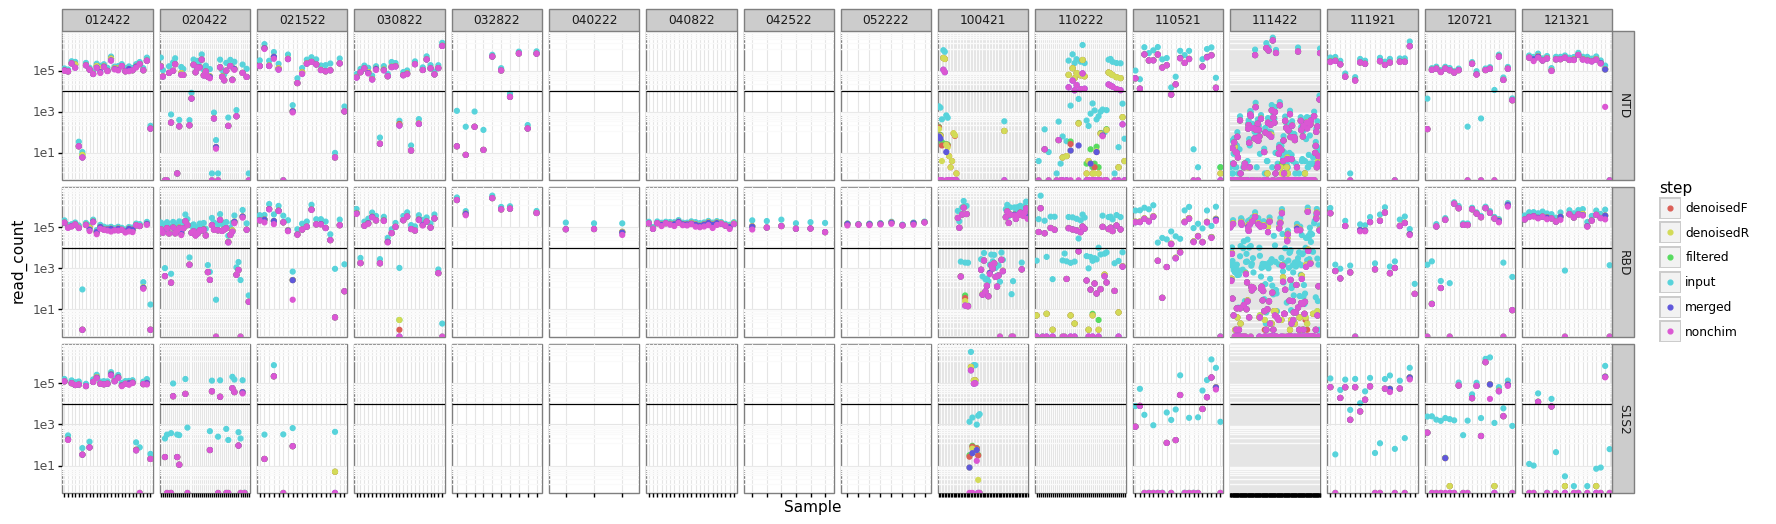

<ggplot: (376588008)>

In [64]:
(ggplot(read_tracking_melt, aes(x='Sample', y='read_count', color='step'))+
geom_point()+
geom_hline(yintercept=1e4)+
facet_grid('amplicon~batch', scales='free_x')+
scale_y_log10()+
theme_bw()+
theme(axis_text_x=element_blank(),
     figure_size=(20,6)))

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 258 rows containing missing values.


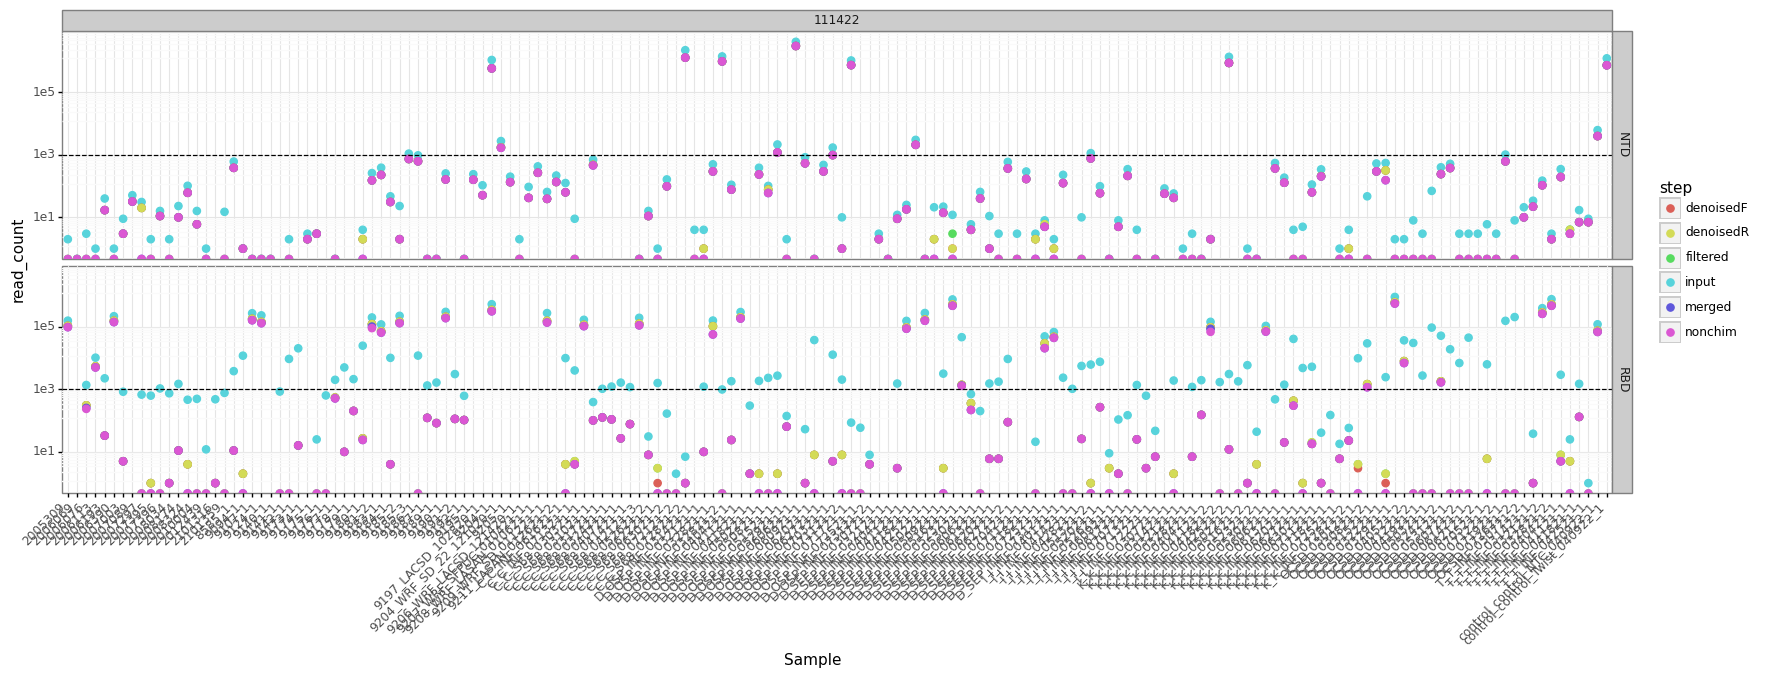

<ggplot: (380022263)>

In [65]:
archive = read_tracking_melt[read_tracking_melt.batch=='111422'].copy()

(ggplot(archive, aes(x='Sample', y='read_count', color='step'))+
geom_point(size=2.5)+
geom_hline(yintercept=1e3, linetype='dashed')+
facet_grid('amplicon~batch', scales='free_x')+
scale_y_log10()+
theme_bw()+
theme(axis_text_x=element_text(angle=45, hjust=1),
     figure_size=(20,6)))

In [31]:
unam = read_tracking_melt[read_tracking_melt.batch=='110222'].copy()
unam.Sample = unam.Sample.astype('string')
order=['2101089', '9181_1', '9185_3', '9194_2',
       'D_OSP_INF_042521_1', 'D_OSP_INF_060621_1', 'D_OSP_INF_062721_1',
       'D_SEP_INF_071121_1', 'OCSD_071221_2', 'C_C_INF_060821_1', 'control_control_Twist_040922_1',
       'D_OSP_INF_052321_1', 'I_I_INF_071321_1', 'K_K_INF_050221_1',
       'OCSD_030121_1', 'OCSD_042621_1', 
       'UNAM_1', 'UNAM_2', 'UNAM_3', 'UNAM_4', 'UNAM_5', 'UNAM_6', 'UNAM_7', 'UNAM_8', 'UNAM_9', 
       'UNAM_10', 'UNAM_11', 'UNAM_12', 'UNAM_13', 'UNAM_14', 'UNAM_15', 'UNAM_16', 'UNAM_17','UNAM_18', 'UNAM_19',
       'UNAM_20', 'UNAM_21', 'UNAM_22', 'UNAM_23', 'UNAM_24', 'UNAM_25', 'UNAM_26', 'UNAM_27', 'UNAM_28',
       'UNAM_29']

unam['samples_ordered'] = pd.Categorical(unam.Sample, categories = order, ordered=True)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 27 rows containing missing values.


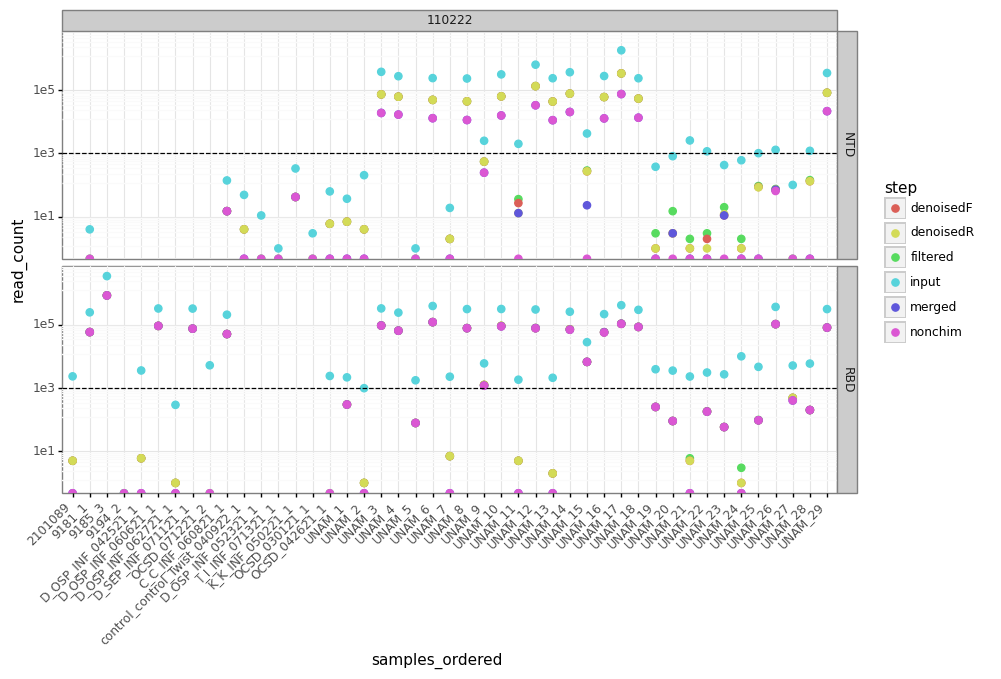

<ggplot: (370290848)>

In [35]:
(ggplot(unam, aes(x='samples_ordered', y='read_count', color='step'))+
geom_point(size=2.5)+
geom_hline(yintercept=1e3, linetype='dashed')+
facet_grid('amplicon~batch', scales='free_x')+
scale_y_log10()+
theme_bw()+
theme(axis_text_x=element_text(angle=45, hjust=1),
     figure_size=(10,6)))

In [45]:
# unam[(unam.step=='nonchim') &
#      (unam.amplicon=='RBD') &
#      (unam.read_count>=1000) & 
#      (unam.Sample.str.startswith('UNAM_'))].sort_values('samples_ordered')

,Sample,batch,amplicon,step,read_count,samples_ordered
3775,UNAM_3,110222,RBD,nonchim,92626.0,UNAM_3
3776,UNAM_4,110222,RBD,nonchim,63847.0,UNAM_4
3778,UNAM_6,110222,RBD,nonchim,119059.0,UNAM_6
3780,UNAM_8,110222,RBD,nonchim,76688.0,UNAM_8
3781,UNAM_9,110222,RBD,nonchim,1176.0,UNAM_9
3754,UNAM_10,110222,RBD,nonchim,87201.0,UNAM_10
3756,UNAM_12,110222,RBD,nonchim,76155.0,UNAM_12
3758,UNAM_14,110222,RBD,nonchim,68465.0,UNAM_14
3759,UNAM_15,110222,RBD,nonchim,6617.0,UNAM_15
3760,UNAM_16,110222,RBD,nonchim,55900.0,UNAM_16


# Plot sequencing progress

## Archive plot

In [54]:
read_tracking.head()

,Sample,input,filtered,denoisedF,denoisedR,merged,nonchim,amplicon,batch,sample_code,date_string,date_sampling
1,C_C_INF_011222_4,437593.0,170069.0,170069.0,170063.0,162687.0,161783.0,NTD,020422,C_C_INF,011222,2022-01-12
2,C_C_INF_012022_4,106800.0,53567.0,53567.0,53564.0,51929.0,51877.0,NTD,020422,C_C_INF,012022,2022-01-20
3,C_C_INF_120221_1,0.0,0.0,NaN,NaN,NaN,0.0,NTD,020422,C_C_INF,120221,2021-12-02
4,C_C_INF_120821_1,0.0,0.0,NaN,NaN,NaN,0.0,NTD,020422,C_C_INF,120821,2021-12-08
5,control_control_bCoV_012122_F30,1.0,0.0,NaN,NaN,NaN,0.0,NTD,020422,control_control_bCoV,012122,2022-01-21


In [198]:
# load read tracking table
read_tracking = []
for f in files:
    batch, amplicon = re.search(r'.+\/.+_sgene_(\d+).+\/(\w+)_read_tracking.csv', f).groups()
    df = pd.read_csv(f)
    df['amplicon'] = amplicon
    df['batch'] = batch
    read_tracking.append(df)
read_tracking = pd.concat(read_tracking)
read_tracking = read_tracking.rename(columns={'Row.names':'Sample'})
read_tracking.loc[read_tracking.nonchim.isna(), 'nonchim'] = 0

# drop controls and UNAM samples
read_tracking = read_tracking[~read_tracking.Sample.str.contains('control')].copy()
read_tracking = read_tracking[~read_tracking.Sample.str.startswith('UNAM')].copy()

# fix messed up names (for aligning with location and plotting)
read_tracking.loc[read_tracking.Sample=='D_OSP_031022_3', 'Sample'] = 'D_OSP_INF_031022_3'
read_tracking.loc[read_tracking.Sample=='D_OSP_031422_4', 'Sample'] = 'D_OSP_INF_031422_4'

# fix samples from Aug 2021 when multiple methods were tried: STD and rRd are duplicates, just keep rRd
# the ones starting with RBD and NTD were done inhouse, just remove the prefix
read_tracking = read_tracking[~read_tracking.Sample.str.startswith('STD_')].copy() # drop (parallel to rRd samples)

misnamed_df = read_tracking[(read_tracking.Sample.str.startswith('rRd_')) |
                            (read_tracking.Sample.str.startswith('RBD_')) | 
                            (read_tracking.Sample.str.startswith('NTD_')) ].copy()

misnamed_df[['treatment', 'sample_id']] = misnamed_df.Sample.str.extract(r'(\w+)_(.+_.+_.+_\d+_\d+)')

# drop misnamed samples from the df, then add back in
read_tracking = read_tracking[~read_tracking.Sample.isin(misnamed_df.Sample)]
read_tracking['sample_id'] = read_tracking.Sample
read_tracking = pd.concat([read_tracking, misnamed_df])
read_tracking = read_tracking.drop(columns='Sample')

# look-up sample names
sample_df_archive_QB3 = pd.read_csv('/Users/rosekantor/data/wbe_scv/qb3_sgene_110222/sample_table_renamed.csv')
sample_df_archive_UCD = pd.read_csv('/Users/rosekantor/data/wbe_scv/ucdavis_sgene_111422/sample_table_renamed.csv')
samples_archive = pd.concat([sample_df_archive_UCD, sample_df_archive_QB3])
samples_archive = samples_archive[['sample_id', 'merge_id']]
samples_archive = samples_archive.drop_duplicates()

read_tracking = read_tracking.merge(samples_archive, how='left', on='sample_id')

# if there is a name in the merge_id column, set sample_id column equal to that name
read_tracking.loc[~read_tracking.merge_id.isna(), 'sample_id'] = read_tracking.merge_id

read_tracking[read_tracking.sample_id == '8585_1']

# extract sample code out of the Sample name
read_tracking[['sample_code', 'date_string']] = read_tracking.sample_id.str.extract(r'(.+_.+_.*)_(\d{6})_.*')
read_tracking['date_sampling'] = pd.to_datetime(read_tracking.date_string, format='%m%d%y') #read_tracking.date_string.apply(lambda x: datetime.strptime(x, '%m%d%y')) # 

# note that samples from August 2021 where multiple methods were tried and sample names are odd
amplicon = 'RBD'
read_tracking_amplicon = read_tracking[(read_tracking.amplicon == amplicon)][['sample_id', 'nonchim', 'date_sampling', 'sample_code']].copy()

In [199]:
# instead using the parsing above to get to the date and then pulling site metadata from this file
sites_df = pd.read_csv('/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/site_lookup_sequencing.csv')

sites_add = pd.DataFrame.from_records([['OCSD_P1_INF', 'Orange County', 'Orange County SD'],
['SDPU_PtLom_INF', 'San Diego', 'San Diego Pt. Loma']], columns=['sample_code', 'county', 'site_full_name'])
sites_df = sites_df.append(sites_add)

read_tracking_amplicon = sites_df.merge(read_tracking_amplicon, how='right', on='sample_code').reset_index(drop=True)

# make sure controls and any other samples without names keep their names (since they don't have county or site names)

#read_tracking_amplicon.date_sampling = pd.to_datetime(read_tracking_amplicon.date_sampling)
read_tracking_amplicon = read_tracking_amplicon.sort_values(['site_full_name', 'date_sampling'])

#read_tracking_amplicon[['merge_id']].drop_duplicates().head()
read_tracking_amplicon

,utility_name,county,utility,facility,site,sample_code,sample_level,sampling_days,sampling_frequency_per_week,site_full_name,site_description,site_pretreatment,site_population_served,name,owner,sample_id,nonchim,date_sampling
328,CMSA,Marin,B,B,INF,B_B_INF,Influent,NaN,2.0,CMSA influent,old,NaN,105000.0,B_B_INF,Rose Kantor,B_B_INF_032722_4,152342.0,2022-03-27
225,CMSA,Marin,B,B,INF,B_B_INF,Influent,NaN,2.0,CMSA influent,old,NaN,105000.0,B_B_INF,Rose Kantor,B_B_INF_040522_4,76007.0,2022-04-05
44,CMSA,Marin,B,B,INF,B_B_INF,Influent,NaN,2.0,CMSA influent,old,NaN,105000.0,B_B_INF,Rose Kantor,B_B_INF_050322_4,119952.0,2022-05-03
243,Calexico,Imperial,V,V,INF,V_V_INF,Influent,Sunday|Monday|Wednesday,3.0,Calexico,Influent,NaN,40000.0,V_V_INF,Rose Kantor,V_V_INF_100621_1,254766.0,2021-10-06
244,Calexico,Imperial,V,V,INF,V_V_INF,Influent,Sunday|Monday|Wednesday,3.0,Calexico,Influent,NaN,40000.0,V_V_INF,Rose Kantor,V_V_INF_101221_1,18368.0,2021-10-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,CMSA,Marin,B,B,SRWS,B_B_SRWS,Interceptor,Tuesday,2.0,West Railroad,West Railroad (canal area),NaN,12946.0,B_B_SRWS,Rose Kantor,B_B_SRWS_041022_4,94759.0,2022-04-10
45,CMSA,Marin,B,B,SRWS,B_B_SRWS,Interceptor,Tuesday,2.0,West Railroad,West Railroad (canal area),NaN,12946.0,B_B_SRWS,Rose Kantor,B_B_SRWS_050822_4,129583.0,2022-05-08
94,NaN,NaN,NaN,NaN,NaN,Unknown_5089_INF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown_5089_INF_081720_1,4.0,2020-08-17
95,NaN,NaN,NaN,NaN,NaN,Unknown_5089_INF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown_5089_INF_081920_2,130120.0,2020-08-19


In [200]:
read_tracking_amplicon = read_tracking_amplicon[read_tracking_amplicon.sample_code!='Unknown_5089_INF'].copy()

In [201]:
# NWSS sites
nwss = ['Calexico', 'Central San', 'EBMUD Influent', 'City of Bakersfield', 'Novato Sanitary District',
        'Fresno', 'Hyperion', 'Oceanside Treatment Plant', 'San Bernardino', 
        'Southeast Treatment Plant', 'LA JWPCP', 'Orange County SD', 'San Diego Pt Loma']

In [202]:
read_tracking_amplicon[read_tracking_amplicon.site_full_name.isin(nwss)][['county', 'site_full_name', 'date_sampling']].drop_duplicates().groupby(['site_full_name', 'county']).count().reset_index().to_clipboard(index=False)

In [203]:
# get week of sample and plot each week whether a sample was collected

read_tracking_amplicon['week'] = pd.to_datetime(read_tracking_amplicon['date_sampling']) - pd.to_timedelta(7, unit='d')
df_week = read_tracking_amplicon.groupby(['site_full_name', 'county', pd.Grouper(key='week', freq='W-SUN')]).agg(
                                                                         mean_readcount=('nonchim', 'mean'),
                                                                         sample_count=('nonchim', 'count')
                                                                        ).reset_index()

# get nice names for y-axis and sort so they appear in order
df_week['county_site'] = df_week[['county', 'site_full_name']].apply(lambda x: ': '.join(x), axis=1)
df_week = df_week.sort_values(['county', 'site_full_name'])
df_week.county_site = df_week.county_site.astype('category')
df_week.county_site = pd.Categorical(df_week.county_site,
                                      categories=df_week.county_site.unique().tolist()[::-1], ordered=True)

df_week['log10_readcount'] = np.log10(df_week.mean_readcount)
df_week['success'] = df_week.mean_readcount > 1000

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10


In [204]:
df_week.site_full_name.unique()

array(['Clark Kerr', 'EBMUD Influent', 'Piedmont and Channing',
       'South_Oakland', 'Central San', 'Delta Diablo', 'West County SD',
       'Fresno', 'Calexico', 'City of Bakersfield', 'Hyperion',
       'LA JWPCP', 'CMSA influent', 'Las Gallinas Sanitary District',
       'Novato Sanitary District', 'West Railroad',
       'City of American Canyon', 'Orange County SD',
       'Newhall and Fairfax trunk line', 'Oceanside Treatment Plant',
       'Southeast Treatment Plant', 'San Bernardino',
       'San Diego Pt. Loma', 'California Medical Facility',
       'City of Vacaville'], dtype=object)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 12 x 4 in image.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /Users/rosekantor/data/wbe_scv/results_sgene/CDPH_seq_success.png


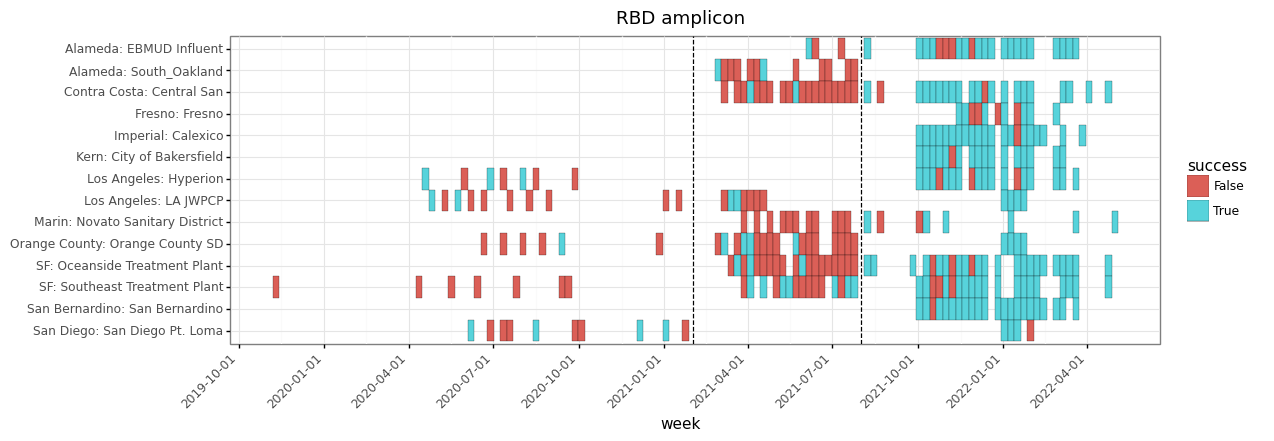

<ggplot: (380015879)>

In [205]:
# plot
# drop non-NWSS sites
drop = ['Delta Diablo', 'California Medical Facility', 
        'Clark Kerr', 'Piedmont and Channing',
        'CMSA influent', 'Las Gallinas Sanitary District', 'West Railroad',
        'Newhall and Fairfax trunk line', 'West County SD', 'City of Vacaville', 'City of American Canyon'
       ]
plt = (ggplot(df_week[~df_week.site_full_name.isin(drop)], aes(x='week', y='county_site', fill='success'))+ #y='site_full_name # change to this if faceting by county works
 geom_tile(color='black')+
 geom_vline(xintercept='2021-08-01', linetype='dashed')+
 geom_vline(xintercept='2021-02-01', linetype='dashed')+
 #geom_text(aes(label='sample_count'), color='white')+
ggtitle('RBD amplicon')+
 theme_bw()+
 #scale_x_datetime(breaks = df_week.week.unique())+
 ylab('')+
 #facet_grid('county ~', scales='free_y', space='free_y')+ #not yet implemented in plotnine
 theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(12, 4)))

ggsave(plt, '/Users/rosekantor/data/wbe_scv/results_sgene/CDPH_seq_success.png')

plt

## original plot

In [59]:
read_tracking[['sample_code', 'date_string']] = read_tracking.Sample.str.extract(r'(.+_.+_.*)_(\d{6})_.*')
read_tracking['date_sampling'] = pd.to_datetime(read_tracking.date_string, format='%m%d%y') #read_tracking.date_string.apply(lambda x: datetime.strptime(x, '%m%d%y')) # 

# dealing with samples from August where multiple methods were tried and sample names are odd we will just drop them for now.

read_tracking = read_tracking[read_tracking.date_sampling > '2021-09-01']

amplicon = 'RBD'
read_tracking_amplicon = read_tracking[(~read_tracking.Sample.str.contains('control')) & (read_tracking.amplicon == amplicon)][['Sample', 'nonchim', 'date_sampling', 'sample_code']].copy()
read_tracking_amplicon[['treatment', 'merge_id']] = read_tracking_amplicon.Sample.str.extract(r'(\w+)_(.+_.+_.+_\d+_\d+)')
read_tracking_amplicon.reset_index(inplace=True)
read_tracking_amplicon.loc[read_tracking_amplicon.merge_id.isna(), 'merge_id'] = read_tracking_amplicon.Sample
read_tracking_amplicon = read_tracking_amplicon.drop(columns='Sample')

In [60]:
# instead using the parsing above to get to the date and then pulling site metadata from this file
sites_df = pd.read_csv('/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/site_lookup_sequencing.csv')
read_tracking_amplicon = sites_df.merge(read_tracking_amplicon, how='right', on='sample_code').reset_index(drop=True)

# make sure controls and any other samples without names keep their names (since they don't have county or site names)

#read_tracking_amplicon.date_sampling = pd.to_datetime(read_tracking_amplicon.date_sampling)
read_tracking_amplicon = read_tracking_amplicon.sort_values(['site_full_name', 'date_sampling'])

In [61]:
read_tracking_amplicon[['merge_id']].drop_duplicates().head()

,merge_id
126,B_B_INF_032722_4
57,V_V_INF_100621_1
58,V_V_INF_101221_1
94,V_V_INF_102021_1
95,V_V_INF_102721_1


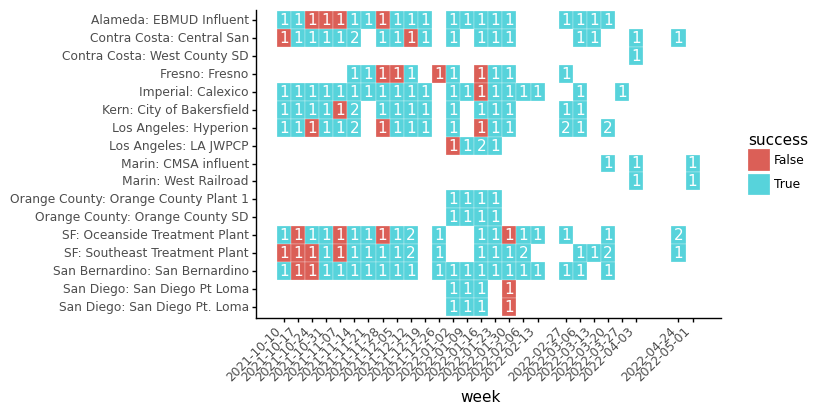

<ggplot: (377247163)>

In [32]:
# plot
# drop non-NWSS sites
drop = ['Delta Diablo', 'California Medical Facility']
plt = (ggplot(df_week[~df_week.site_full_name.isin(drop)], aes(x='week', y='county_site', fill='success'))+ #y='site_full_name # change to this if faceting by county works
 geom_tile(color='white')+
 geom_text(aes(label='sample_count'), color='white')+
 theme_classic()+
 scale_x_datetime(breaks = df_week.week.unique())+
 ylab('')+
 #facet_grid('county ~', scales='free_y', space='free_y')+ #not yet implemented in plotnine
 theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(6, 4)))
plt

In [62]:
## pulling info in from the N1 qPCR results- this only works if samples are exactly named or if we can set merge_id to find a matching sample
#qpcr_data = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/full_wastewater_dataset_newformat_withResidential.csv'
#samples_df = pd.read_csv(qpcr_data)
# make informative sample names
# names_df = samples_df[['Sample', 'county', 'site_full_name', 'date_sampling']].copy()
# names_df['sample_name'] = names_df[['county', 'site_full_name', 'date_sampling']].agg('_'.join, axis=1)
# read_tracking_amplicon = names_df.merge(read_tracking_amplicon, how='right', left_on='Sample', right_on='merge_id').reset_index(drop=True)


# read_tracking_amplicon['date_sampling'] = pd.to_datetime(read_tracking_amplicon['date_sampling'])
# read_tracking_amplicon['week'] = read_tracking_amplicon.date_sampling.dt.isocalendar().week


# get week of sample and plot each week whether a sample was collected

read_tracking_amplicon['week'] = pd.to_datetime(read_tracking_amplicon['date_sampling']) - pd.to_timedelta(7, unit='d')
df_week = read_tracking_amplicon.groupby(['site_full_name', 'county', pd.Grouper(key='week', freq='W-SUN')]).agg(
                                                                         mean_readcount=('nonchim', 'mean'),
                                                                         sample_count=('nonchim', 'count')
                                                                        ).reset_index()

#df_week['week'] = df_week.week.apply(lambda x: datetime.strptime(x + '-1', "%Y-%W-%w"))

# get nice names for y-axis and sort so they appear in order
df_week['county_site'] = df_week[['county', 'site_full_name']].apply(lambda x: ': '.join(x), axis=1)
df_week = df_week.sort_values(['county', 'site_full_name'])
df_week.county_site = df_week.county_site.astype('category')
df_week.county_site = pd.Categorical(df_week.county_site,
                                      categories=df_week.county_site.unique().tolist()[::-1], ordered=True)

df_week['log10_readcount'] = np.log10(df_week.mean_readcount)
df_week['success'] = df_week.mean_readcount > 10000
# drop
drop_sites = ['Clark Kerr', 'Piedmont and Channing', 'City of American Canyon', 
              'City of Vacaville', 'Newhall and Fairfax trunk line', 'Las Gallinas Sanitary District',
              'Novato Sanitary District']
df_week = df_week[(~df_week.site_full_name.isin(drop_sites)) & (df_week.week >= '2021-10-04')]

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10


In [63]:
df_week.head()

,site_full_name,county,week,mean_readcount,sample_count,county_site,log10_readcount,success
60,EBMUD Influent,Alameda,2021-10-10,174130.0,1,Alameda: EBMUD Influent,5.240874,True
61,EBMUD Influent,Alameda,2021-10-17,472682.0,1,Alameda: EBMUD Influent,5.674569,True
62,EBMUD Influent,Alameda,2021-10-24,723.0,1,Alameda: EBMUD Influent,2.859138,False
63,EBMUD Influent,Alameda,2021-10-31,0.0,1,Alameda: EBMUD Influent,-inf,False
64,EBMUD Influent,Alameda,2021-11-07,18.0,1,Alameda: EBMUD Influent,1.255273,False


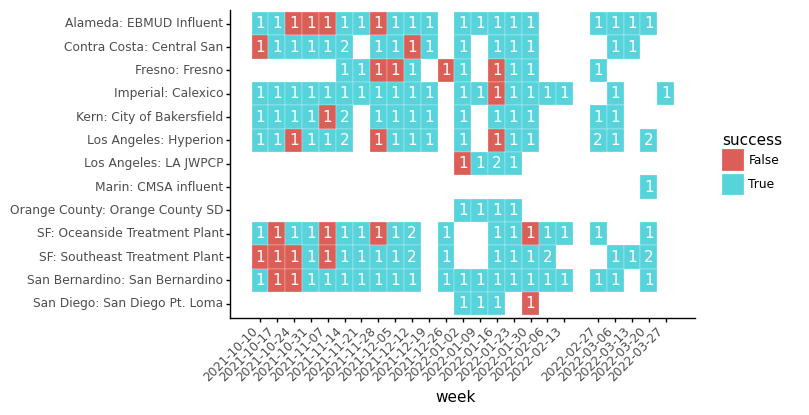

<ggplot: (379396093)>

In [64]:
# plot
# drop non-NWSS sites
drop = ['Delta Diablo', 'California Medical Facility']
plt = (ggplot(df_week[~df_week.site_full_name.isin(drop)], aes(x='week', y='county_site', fill='success'))+ #y='site_full_name # change to this if faceting by county works
 geom_tile(color='white')+
 geom_text(aes(label='sample_count'), color='white')+
 theme_classic()+
 scale_x_datetime(breaks = df_week.week.unique())+
 ylab('')+
 #facet_grid('county ~', scales='free_y', space='free_y')+ #not yet implemented in plotnine
 theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(6, 4)))
plt

In [65]:
df_week[~df_week.site_full_name.isin(drop)].sample_count.sum()

180

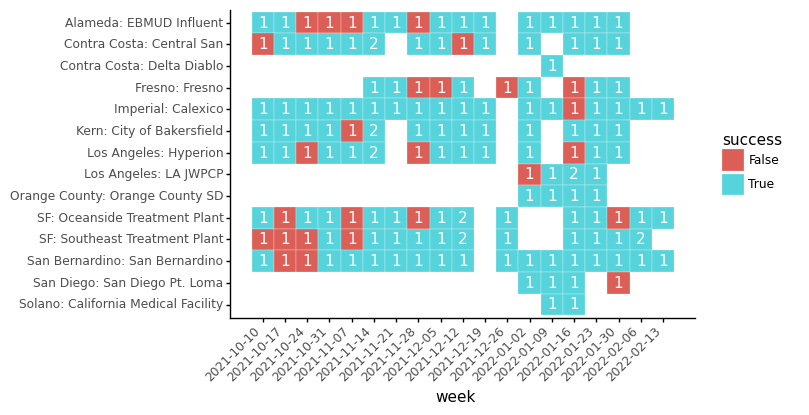

<ggplot: (330676782)>

In [56]:
# plot
plt = (ggplot(df_week, aes(x='week', y='county_site', fill='success'))+ #y='site_full_name # change to this if faceting by county works
 geom_tile(color='white')+
 geom_text(aes(label='sample_count'), color='white')+
 theme_classic()+
 scale_x_datetime(breaks = df_week.week.unique())+
 ylab('')+
 #facet_grid('county ~', scales='free_y', space='free_y')+ #not yet implemented in plotnine
 theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(6, 4)))
plt

In [21]:
display(len(df_week[df_week.mean_readcount >= 3000])) # 33
display(len(df_week)) # 96

107

131

In [200]:
# as a table:

df_week[['county_site', 'week', 'mean_readcount']].pivot(index='county_site', columns='week').reset_index()

county_site      mean_readcount                      \
week                                  2021-10-10 00:00:00 2021-10-17 00:00:00   
0             Alameda: EBMUD Influent            174130.0            472682.0   
1           Contra Costa: Central San              3011.0             61959.0   
2                     Fresno: Fresno                  NaN                 NaN   
3                  Imperial: Calexico             18368.0            201502.0   
4           Kern: City of Bakersfield             29599.0            111758.0   
5              Los Angeles: Hyperion             172552.0            175403.0   
6     Marin: Novato Sanitary District              1132.0                 NaN   
7       SF: Oceanside Treatment Plant            187322.0               316.0   
8       SF: Southeast Treatment Plant              2295.0               620.0   
9      San Bernardino: San Bernardino             18166.0               564.0   

                                                                  \
week 2021-10-24 00:00:00 2021-10-31 00:00:00 2021-11-07 00:00:00   
0                  723.0                 0.0                18.0   
1                62220.0            127672.0            125583.0   
2                    NaN                 NaN                 NaN   
3               509072.0            302450.0            834114.0   
4               157236.0            170626.0                 0.0   
5                  871.0            738256.0            453408.0   
6                    NaN           1099285.5                 NaN   
7               112819.0            106806.0               108.0   
8                    0.0            226562.0                 0.0   
9                 1021.0            489501.0            258856.0   

                                                                  \
week 2021-11-14 00:00:00 2021-11-21 00:00:00 2021-11-28 00:00:00   
0               234165.0            305291.0                51.0   
1               224094.0                 NaN               922.0   
2               394838.0            272332.0                49.0   
3               421710.0            291634.0               137.0   
4               154100.5                 NaN               109.0   
5               112824.5                 NaN               239.0   
6                    NaN                 NaN                 NaN   
7               332814.0            265249.0                67.0   
8               322958.0            241209.0                41.0   
9               413753.0            367334.0               168.0   

                                                                  \
week 2021-12-05 00:00:00 2021-12-12 00:00:00 2021-12-19 00:00:00   
0                   47.0                 NaN             91608.0   
1                  131.0                 NaN             64221.0   
2                   38.0            112681.0                 NaN   
3                  204.0             67640.0             60520.0   
4                  350.0             61494.0             56888.0   
5                  168.0             44905.0             83335.0   
6                    NaN                 NaN                 NaN   
7                   35.0            133899.0                 NaN   
8                 1040.0                 1.0                 NaN   
9                  112.0             66909.0                 NaN   

                                              
week 2021-12-26 00:00:00 2022-01-02 00:00:00  
0                    NaN            162493.0  
1                    NaN            124964.0  
2                   99.0            122284.0  
3                    NaN             73371.0  
4                    NaN             54192.0  
5                    NaN            172766.0  
6                    NaN                 NaN  
7               107529.0                 NaN  
8                89982.0                 NaN  
9                73498.0             69631.0

# NCBI submission

In [190]:
df = []
for f in glob('/Users/rosekantor/data/wbe_scv/qb3_sgene_*/sample_table.csv'):
    sample_tab = pd.read_csv(f)
    df.append(sample_tab)
df = pd.concat(df)
df = df.replace('RDB', 'RBD') # I fixed the misnaming of the reads, so now need to fix it in the table

df.read1 = df.read1.str.replace('RDB', 'RBD')
df.read2 = df.read2.str.replace('RDB', 'RBD')

In [191]:
# one sample was rerun on 3/8/22 because it initially failed - remove the original failed sample
dups = ['NTD_LACSD_Jnt_INF_012322_1_S28_L001_R1_001.fastq.gz', 'RBD_LACSD_Jnt_INF_012322_1_S14_L001_R1_001.fastq.gz']
df = df[~df.read1.isin(dups)]

# in the Aug 2021 batch, we compared rRd vs std preps, drop the std preps
df = df[~df.sample_id.str.startswith('std_')]
df.sample_id = df.sample_id.str.replace('rRd_', '')

In [192]:
# for now just submit RBD and drop controls (because the sample names will be identical)
df_rbd = df[(df.amplicon == 'RBD') & (~df.sample_id.str.contains('control'))].copy()

# sample_id for CDC NWSS submission is the same but without replicate number
# so dropping extraction replicates that were sequenced
reps = ['D_SEP_NF_081121_2', 'I_I_INF_110321_2', 'K_K_INF_081121_2', 'K_K_INF_111721_2', 'O_O_INF_081221_2']
df_rbd = df_rbd[~df_rbd.sample_id.isin(reps)]

# rename to match required field
df_rbd = df_rbd.rename(columns = {'sample_id':'sample_name'})

# extract sample date
df_rbd['collection_date'] = df_rbd.sample_name.str.extract(r'.+_.+_.+_(.+)_.+')
df_rbd['collection_date'] = df_rbd['collection_date'].astype('string')
df_rbd['collection_date'] = pd.to_datetime(df_rbd.collection_date, format="%m%d%y")

# extract sample code
df_rbd['sample_code'] = df_rbd.sample_name.str.extract(r'(.+_.+_.+)_.+_.+')

# change sample name to drop the extraction replicate so that it matches the name in CDC NWSS
df_rbd['sample_name'] = df_rbd.sample_name.str.extract(r'(.+_.+_.+_.+)_.+')


df_rbd['organism'] = 'wastewater metagenome'
df_rbd['geo_loc_name'] = 'USA: California'
df_rbd['isolation_source'] = 'raw wastewater'
df_rbd['ww_sample_duration'] = 24
df_rbd['ww_sample_matrix'] = 'raw wastewater'
df_rbd['ww_sample_type'] = 'composite'
df_rbd['ww_surv_target_1'] = 'SARS-CoV-2'
df_rbd['ww_surv_target_1_known_present'] = 'yes'
df_rbd['collected_by'] = 'Wastewater agency'
df_rbd['purpose_of_ww_sequencing'] = 'identification of mutations in S gene'
df_rbd['sequenced_by'] = 'UC Berkeley'

In [193]:
df_pop = pd.read_csv('/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/site_lookup_031722.csv')

In [194]:
# pull in population data
df_pop = pd.read_csv('/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/site_lookup_031722.csv')
df_pop = df_pop[['sample_code', 'site_population_served']]
df_pop.columns = ['sample_code', 'ww_population']

df_rbd = df_rbd.merge(df_pop, how='left', on='sample_code')

df_rbd.loc[df_rbd.ww_population.isna(), 'ww_population'] = 'NA'

# we don't have population info for samples sent from CDPH (LACSD, OCSD, and SDPU), found online
df_rbd.loc[df_rbd.sample_code == 'LACSD_Jnt_INF', 'ww_population'] = 4800000
df_rbd.loc[df_rbd.sample_code == 'OCSD_P1_INF', 'ww_population'] = 2000000
df_rbd.loc[df_rbd.sample_code == 'SDPU_PtLom_INF', 'ww_population'] = 2200000

In [195]:
df_rbd[['sample_name', 'read1', 'read2']].to_csv('/Users/rosekantor/data/wbe_scv/NCBI_submission_sgene/SRA_table_cols.tsv', sep='\t', index=False)

In [174]:
sample_tab = df_rbd.drop(columns=['read1', 'read2', 'read_name', 'amplicon', 'merge_id', 'datadir', 'treatment', 'sample_code']).copy()

In [166]:
sample_tab.to_csv('/Users/rosekantor/data/wbe_scv/NCBI_submission_sgene/sample_table.tsv', sep='\t', index=False)

In [197]:
dest = '/Users/rosekantor/data/wbe_scv/NCBI_submission_sgene/files'
with open('/Users/rosekantor/data/wbe_scv/NCBI_submission_sgene/copy_files.sh', 'w') as f:
    for r in df_rbd.itertuples():
        f.write(f'cp {r.datadir}/raw/{r.read1} {dest}/{r.read1}\n')
        f.write(f'cp {r.datadir}/raw/{r.read2} {dest}/{r.read2}\n')
f.close()

In [196]:
df_rbd[['sample_name', 'read1', 'read2', 'datadir']].tail()

,sample_name,read1,read2,datadir
187,V_V_INF_110921,RBD_V_V_INF_110921_1_S4_L001_R1_001.fastq.gz,RBD_V_V_INF_110921_1_S4_L001_R2_001.fastq.gz,/Users/rosekantor/data/wbe_scv/qb3_sgene_120721
188,W_W_INF_110421,RBD_W_W_INF_110421_1_S5_L001_R1_001.fastq.gz,RBD_W_W_INF_110421_1_S5_L001_R2_001.fastq.gz,/Users/rosekantor/data/wbe_scv/qb3_sgene_120721
189,W_W_INF_110921,RBD_W_W_INF_110921_1_S6_L001_R1_001.fastq.gz,RBD_W_W_INF_110921_1_S6_L001_R2_001.fastq.gz,/Users/rosekantor/data/wbe_scv/qb3_sgene_120721
190,X_2_INF_110421,RBD_X_2_INF_110421_1_S1_L001_R1_001.fastq.gz,RBD_X_2_INF_110421_1_S1_L001_R2_001.fastq.gz,/Users/rosekantor/data/wbe_scv/qb3_sgene_120721
191,X_2_INF_111021,RBD_X_2_INF_111021_1_S2_L001_R1_001.fastq.gz,RBD_X_2_INF_111021_1_S2_L001_R2_001.fastq.gz,/Users/rosekantor/data/wbe_scv/qb3_sgene_120721


In [ ]:
# uploading the files using lftp to connect to NCBI server:

# tar -cvf uploads.tar files/
# lftp -u subftp,password ftp-private.ncbi.nlm.nih.gov
# cd uploads/rkantor_berkeley.edu_3SC2ybIi
# mkdir rbd_091622
# cd rbd_091622
# put uploads.tar


# track just batch 12/23/21

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  margin_vars = [list(data.columns & self.rows),
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  list(data.columns & self.cols)]
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/layer.py:452: PlotnineWarning

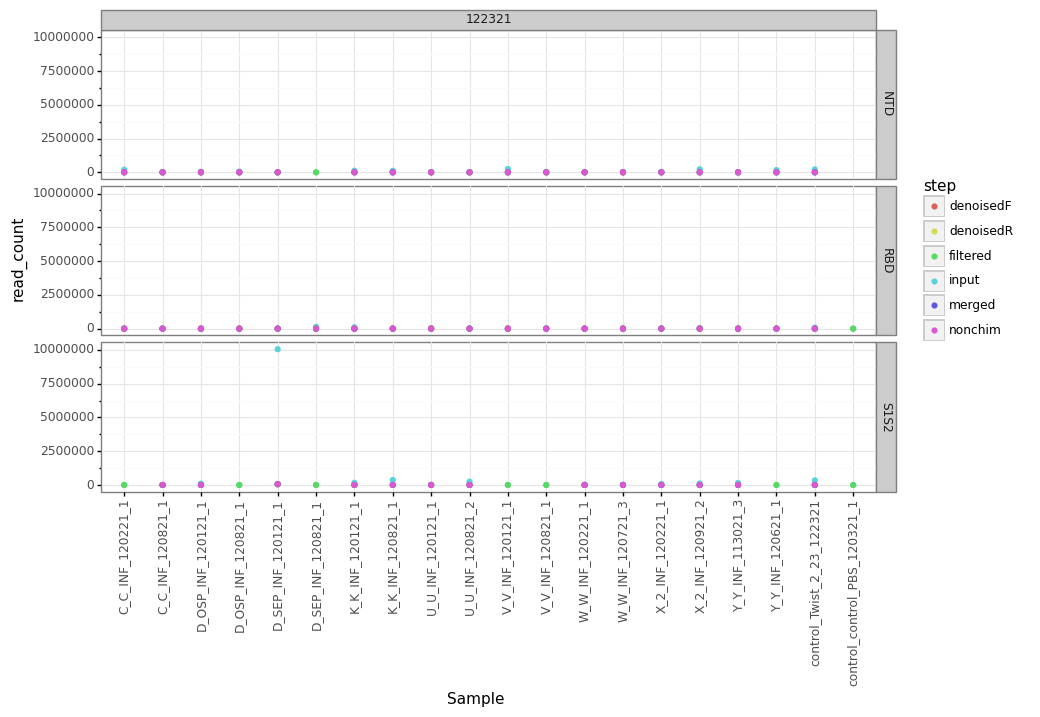

<ggplot: (350137778)>

In [40]:
(ggplot(read_tracking_melt[read_tracking_melt.batch=='122321'], aes(x='Sample', y='read_count', color='step'))+
geom_point()+
facet_grid('amplicon~batch', scales='free_x')+
#scale_y_log10()+
theme_bw()+
theme(axis_text_x=element_text(angle=90, hjust=1.1),
     figure_size=(10,6)))

In [62]:
raw_df = pd.read_csv('/Users/rosekantor/data/wbe_scv/qb3_sgene_122321/raw/reads_counts_raw.txt', sep=':', names=['filename', 'total', 'count'])
raw_df[['amplicon', 'sample_id']] = raw_df.filename.str.extract(r'(\w{3,4})_(.+)_S\d+_L001_R._001\.fastq\.gz.*')

In [64]:
raw_df = raw_df.drop(columns=['total','filename'])
# these samples got misnamed with the shorthand name
raw_df.sample_id = raw_df.sample_id.str.replace(r'C_INF', 'C_C_INF')
raw_df.sample_id = raw_df.sample_id.str.replace(r'K_INF', 'K_K_INF')
raw_df.sample_id = raw_df.sample_id.str.replace(r'U_INF', 'U_U_INF')
raw_df.sample_id = raw_df.sample_id.str.replace(r'V_INF', 'V_V_INF')
raw_df.sample_id = raw_df.sample_id.str.replace(r'W_INF', 'W_W_INF')
raw_df.sample_id = raw_df.sample_id.str.replace(r'Y_INF', 'Y_Y_INF')

In [67]:
raw_df.sort_values('count', ascending=False).head() # most of the pool was S1S2 D_SEP_INF_120121_

,count,amplicon,sample_id
43,"10,312,784",S1S2,D_SEP_INF_120121_1
46,"378,077",S1S2,K_K_INF_120821_1
57,"346,899",S1S2,control_Twist_2_23_122321
48,"251,171",S1S2,U_U_INF_120821_2
10,"250,085",NTD,V_V_INF_120121_1


In [43]:
read_tracking_melt[(read_tracking_melt.batch=='122321') & (read_tracking_melt.step=='nonchim')]

,Sample,batch,amplicon,step,read_count
1715,C_C_INF_120221_1,122321,NTD,nonchim,921.0
1716,C_C_INF_120821_1,122321,NTD,nonchim,0.0
1717,control_Twist_2_23_122321,122321,NTD,nonchim,1052.0
1718,D_OSP_INF_120121_1,122321,NTD,nonchim,314.0
1719,D_OSP_INF_120821_1,122321,NTD,nonchim,224.0
1720,D_SEP_INF_120121_1,122321,NTD,nonchim,49.0
1721,D_SEP_INF_120821_1,122321,NTD,nonchim,NaN
1722,K_K_INF_120121_1,122321,NTD,nonchim,551.0
1723,K_K_INF_120821_1,122321,NTD,nonchim,359.0
1724,U_U_INF_120121_1,122321,NTD,nonchim,89.0


# Reviewing the effect of rRNA depletion

In [72]:
rRd_comp = pd.read_csv('/Users/rosekantor/data/wbe_scv/qb3_sgene_100421/results/dada2_out/RBD_read_tracking.csv')
rRd_comp[['treatment', 'Sample']] = rRd_comp['Row.names'].str.extract('(\w+)_(.+_.+_.+_.+_.+)')
rRd_comp = rRd_comp.drop(columns='Row.names')
rRd_comp = rRd_comp.melt(id_vars=['Sample', 'treatment'])
rRd_comp.loc[rRd_comp.treatment=='RBD', 'treatment'] = 'in-house'

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


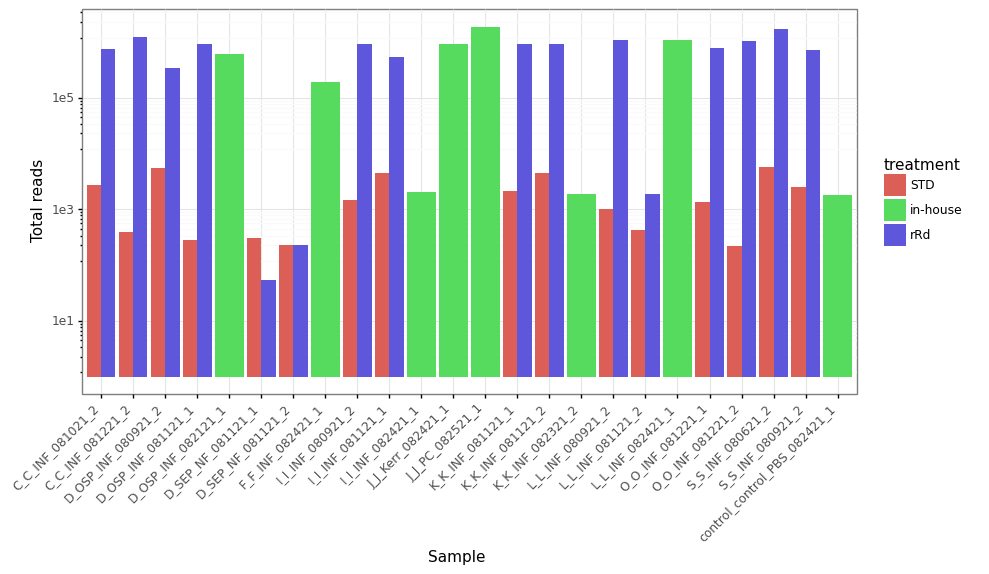

<ggplot: (359187185)>

In [76]:
(ggplot(rRd_comp[(rRd_comp.variable=='input') ], aes(x='Sample', y='value', fill='treatment'))+
#geom_point()+
geom_bar(stat='identity', position='dodge')+
 scale_y_log10()+
 ylab('Total reads')+
#facet_wrap('~treatment')+
theme_bw()+
theme(figure_size=(10, 5), axis_text_x=element_text(angle=45, hjust=1)))

# Track concentrations

In [127]:
df_data = pd.read_csv('/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/full_wastewater_dataset_newformat_withResidential.csv')
df_data.date_sampling = pd.to_datetime(df_data.date_sampling)

In [153]:
df_data[['Sample', 'dilution', 'Cq', 'Quantity_mean', 'Quantity_mean_with_dilution', 'SARS_CoV_2_N1_gc_per_mL']].head()

,Sample,dilution,Cq,Quantity_mean,Quantity_mean_with_dilution,SARS_CoV_2_N1_gc_per_mL
0,M_M_INF_111621_1,1,"[34.29307145, 34.40435994, 34.53392337]",16.700607,16.700607,NaN
1,N_N_INF_071321_3,1,"[34.056723, 35.1605614, 34.9122357]",13.614022,13.614022,13.035569
2,R_R_Alvarado_071321_3,1,"[32.2235552, 32.4522973, 32.57591]",65.097320,65.097320,64.460770
3,Q_Q_CMF_123121_1,5,"[33.91302272, 33.95925181, 34.0383345]",112.772278,22.554456,92.483672
4,Q_Q_CMF_123121_2,5,"[34.05321047, 34.22965938, 34.0146807]",103.268883,20.653777,85.887417


In [128]:
read_tracking_amplicon.date_sampling.head()

126   2022-03-27
57    2021-10-06
58    2021-10-12
94    2021-10-20
95    2021-10-27
Name: date_sampling, dtype: datetime64[ns]

In [155]:
read_tracking_amplicon = read_tracking_amplicon.drop_duplicates('merge_id')

tracking_quantification = read_tracking_amplicon.merge(df_data, how='inner', left_on='merge_id', right_on='sample_id', suffixes=('_seq', '_quant'))
tracking_quantification = tracking_quantification[['sample_id', 'Cq', 'nonchim', 'Quantity_mean', 'date_sampling_quant', 'week']].copy()

tracking_quantification['gc_per_ul_RNA'] = tracking_quantification.Quantity_mean / 5
tracking_quantification['Success'] = tracking_quantification.nonchim >= 10000
tracking_quantification['log10_conc'] = np.log10(tracking_quantification.gc_per_ul_RNA)

tracking_quantification.sort_values('gc_per_ul_RNA').head()

,sample_id,Cq,nonchim,Quantity_mean,date_sampling_quant,week,gc_per_ul_RNA,Success,log10_conc
50,C_C_INF_111021_1,"[35.16562022, 35.91766429, 35.43053404]",18.0,7.914053,2021-11-10,2021-11-03,1.582811,False,0.199429
122,D_SEP_INF_102521_1,"[34.56847762, 34.9235699, 35.01653603]",0.0,12.489124,2021-10-25,2021-10-18,2.497825,False,0.397562
51,C_C_INF_111821_1,"[34.99873273, 34.73580637, 34.50067334]",234165.0,13.290558,2021-11-18,2021-11-11,2.658112,True,0.424573
89,D_OSP_INF_102521_1,"[34.33081481, 35.32979205, 34.40897162]",112819.0,13.800955,2021-10-25,2021-10-18,2.760191,True,0.440939
61,Y_Y_INF_113021_3,"[34.99668946, 33.96684784, 34.72106994]",814.0,15.064244,2021-11-30,2021-11-23,3.012849,False,0.478977


Sequencing success is not really determined by concentration.

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10


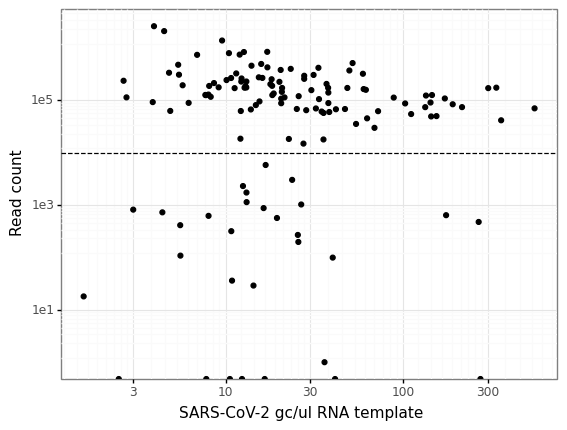

<ggplot: (360545049)>

In [151]:
(ggplot(tracking_quantification, aes(x='gc_per_ul_RNA', y='nonchim'))+
geom_point()+
geom_hline(yintercept=1e4, linetype = 'dashed')+
scale_x_log10()+
scale_y_log10()+
 ylab('Read count')+
 xlab('SARS-CoV-2 gc/ul RNA template')+
theme_bw())

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10


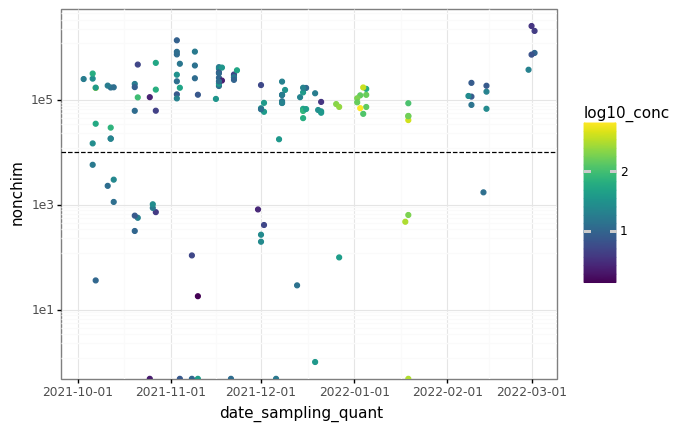

<ggplot: (359861914)>

In [137]:
(ggplot(tracking_quantification, aes(x='date_sampling_quant', y='nonchim', color='log10_conc'))+
geom_point()+
geom_hline(yintercept=1e4, linetype = 'dashed')+
scale_y_log10()+
theme_bw())